# Modeling Housing Prices 2018 - 2022

<i> Bushra Islam, Ha Bui, Geeta Apodaca, Ramya Venkatesan, Karthigalakshmi Ramasamy, Elizabeth Hall, and Ewa Godlewska </i>

---



## Set-Up
Set up the Google Drive to pull files. Files can also be imported directly when downloaded from GitHub. 

In [3]:
# to load the housing data drive go to google drive, 
# right click the housing data folder and add shortcut to drive, save in MyDrive

# mount google drive with data folders
from google.colab import drive
drive.mount('/content/drive/')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

Mounted at /content/drive/


In [ ]:
!pip install prophet
!pip install pmdarima

# Data processing
import numpy as np
import pandas as pd
import pmdarima as pm
from pandas import DataFrame
from datetime import datetime,timedelta
from numpy import concatenate
import tensorflow as tf
from pandas import concat
from pandas import DataFrame


# modeling
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Visualization
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Loading in the modeling data, subsetting the correct years, and splitting in to test and train

In [24]:
# load the data from the drive
df = pd.read_csv ('/content/drive/MyDrive/ds4_housing_data/housing_data_for_modeling_v2.csv')

# set the time to pd datetime format
df['time']=pd.to_datetime(df['time'])
df = df.loc[df['time'] < '2022-06-01']

df_time1_train = df.loc[(df["time"] >= "2005-01-01") & (df["time"]<="2018-12-01")]
df_time1_test = df.loc[df["time"] >= "2019-01-01"]

df_time1_train_raw = df_time1_train
df_time1_test_raw = df_time1_test
df_time1_raw = pd.concat([df_time1_train_raw, df_time1_test_raw])

df_time1_train = df_time1_train.drop(['Unnamed: 0', 'housing_price', 'rental_price', 'inflation_rate',
       'property_tax_rate', 'median_age_homebuyers', 'housing_starts',
       'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate',
       'work_home_rate'],axis=1)
df_time1_test = df_time1_test.drop(['Unnamed: 0', 'housing_price', 'rental_price', 'inflation_rate',
       'property_tax_rate', 'median_age_homebuyers', 'housing_starts',
       'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate',
       'work_home_rate'] ,axis=1)

df_time1 = pd.concat([df_time1_train, df_time1_test])

## ARIMA 
<p> This is an autoregressive intergrated moving average model of housing prices. We set p, d, and q values manually from our observations. </p>

<b> ARIMA (p,d,q) </b>
<br>
<b> p: </b> the number of lag observations in the model, also known as the lag order (it is for AR(p) part). <br>
<b> d: </b>the number of times that the raw observations are differenced; also known as the degree of differencing (we did second difference here). <br>
<b>q: </b>the size of the moving average window; also known as the order of the moving average (it is for MA(q) part)


In [ ]:
ARIMA_model=ARIMA(df_time1_train['diff_housing_price'], order=(1,2,1))

ARIMA_model_fit=ARIMA_model.fit()

df_results=df_time1_test[['time','diff_housing_price']]
col = 'housing_price'
pred_startdate=df_time1_test.index[0]
pred_enddate=df_time1_test.index[-1]

# saving forecasts in "differenced" values to df results to later invert
df_results['ARIMA_Forecast']=ARIMA_model_fit.predict(start=pred_startdate,end=pred_enddate)


## SARIMA
An autoregessive model that includes a trend for seasonality

In [ ]:
#SARIMA Model (takes in to account seasonality, just sarima without exogenous )

SARIMA_model=SARIMAX(df_time1_train['diff_housing_price'],order=(3,0,5),seasonal_order=(0,1,0,12))
SARIMA_model_fit=SARIMA_model.fit()


# save the predicted values 
df_results['predicted_housing_price_SARIMA']=SARIMA_model_fit.predict(start=pred_startdate,end=pred_enddate)
residuals_SARIMA=df_time1_test['diff_housing_price']-df_results['predicted_housing_price_SARIMA']

## ARIMAX 

<p> This is an autoregressive intergrated moving average model of housing prices using exogenous variables. We have the model looping through to find the optimal p, d, and q values. </p>



In [ ]:
# ARIMAX Model, has the exogenous variables
df_time1_train_autoarima = df_time1_train_raw.iloc[:,1:12]
df_time1_test_autoarima = df_time1_test_raw.iloc[:,1:12]

axmodel1 = pm.auto_arima(df_time1_train_autoarima[['housing_price']], exogenous=df_time1_train_autoarima.loc[:,'rental_price':'interest_rate'],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=2, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# save the results to the results df
df_results['predicted_housing_price_ARIMAX1']=axmodel1.predict(exogenous=df_time1_test_autoarima.loc[:,'rental_price':'interest_rate'],n_periods = len(df_time1_test_autoarima))


## SARIMAX
SARIMAX is an autoregressive model that includes a trend for seasonalitity and the exogenous variables.

In [ ]:
#SARIMAX Model with exogenous variables

sxmodel1 = pm.auto_arima(df_time1_train_autoarima[['housing_price']], exogenous=df_time1_train_autoarima.loc[:,'rental_price':'interest_rate'],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=4, max_q=4, m=12,
                           start_P=0, start_Q=0,seasonal=True,
                           d=2, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

df_results['predicted_housing_price_SARIMAX1']=sxmodel1.predict(exogenous=df_time1_test_autoarima.loc[:,'rental_price':'interest_rate'],n_periods = len(df_time1_test))


## LSTM Multivariate
A long short term memory recurrent network model. Learns what sequences and variables are the most predictive are forgets those that are not as predictive. 

In [28]:
# fix random seed for reproducibility
tf.random.set_seed(7)

dataframe2_1 = df_time1

dataframe2 = dataframe2_1.drop(['time'], axis = 1) 

dataset = dataframe2.to_numpy()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_size = int(len(dataset) * len(df_time1_train) / len (dataset)) -1
test_size = len(dataset) - train_size
train, test = values[0:train_size,:], values[train_size:len(dataset),:]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))


#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=5, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#rows_count = len(dataset)
#print(rows_count)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

## Prophet


In [ ]:
# Prophet / Neural Prophet ---> Beth
df_prophet = df_time1_train
df_prophet.columns= ['ds', 'y', 'diff_rental_price',
       'diff_inflation_rate', 'diff_property_tax_rate',
       'diff_median_age_homebuyers', 'diff_housing_starts',
       'diff_mortgage_rate', 'diff_mortgage_to_income_rate',
       'diff_work_home_rate', 'diff_interest_rate']
df_prophet_test = df_time1_test
df_prophet_test.columns = ['ds', 'y', 'diff_rental_price',
       'diff_inflation_rate', 'diff_property_tax_rate',
       'diff_median_age_homebuyers', 'diff_housing_starts',
       'diff_mortgage_rate', 'diff_mortgage_to_income_rate',
       'diff_work_home_rate', 'diff_interest_rate']

# Build and fit a Prophet model
model = Prophet()
model.add_regressor('diff_rental_price', standardize=False)
model.add_regressor('diff_inflation_rate', standardize=False)
model.add_regressor('diff_property_tax_rate', standardize=False)
model.add_regressor('diff_median_age_homebuyers', standardize=False)
model.add_regressor('diff_housing_starts', standardize=False)
model.add_regressor('diff_mortgage_rate', standardize=False)
model.add_regressor('diff_mortgage_to_income_rate', standardize=False)
model.add_regressor('diff_work_home_rate', standardize=False)
model.add_regressor('diff_interest_rate', standardize=False)
model.fit(df_prophet)
# Create a data frame for predictions
future = model.make_future_dataframe(periods=len(df_time1_test), freq='MS')
# Make predictions and print them
forecast = model.predict(df_prophet_test.drop(columns="y"))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

df_results["predicted_housing_price_Prophet"] = list(forecast["yhat"])

## Random Forest 

In [32]:
# create lag of dependent variable to use as one of independent variables
df['lag_y'] = df['diff_housing_price'].shift(1)

# take the two time periods of interest
df_time1_train = df.loc[(df["time"] >= "2005-01-01") & (df["time"]<="2018-12-01")]
df_time1_test = df.loc[df["time"] >= "2019-01-01"]

df_time1_train_raw = df_time1_train
df_time1_test_raw = df_time1_test

df_time1_train = df_time1_train.drop(['Unnamed: 0', 'housing_price', 'rental_price', 'inflation_rate',
       'property_tax_rate', 'median_age_homebuyers', 'housing_starts',
       'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate',
       'work_home_rate'],axis=1)
df_time1_test = df_time1_test.drop(['Unnamed: 0', 'housing_price', 'rental_price', 'inflation_rate',
       'property_tax_rate', 'median_age_homebuyers', 'housing_starts',
       'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate',
       'work_home_rate'] ,axis=1)

df_time1 = pd.concat([df_time1_train, df_time1_test])


# select train & test data (just rename columns here)
df_rf = df_time1_train
df_rf.columns= ['ds', 'y', 'diff_rental_price',
       'diff_inflation_rate', 'diff_property_tax_rate',
       'diff_median_age_homebuyers', 'diff_housing_starts',
       'diff_mortgage_rate', 'diff_mortgage_to_income_rate',
       'diff_work_home_rate', 'diff_interest_rate','lag_y']
df_rf_test = df_time1_test
df_rf_test.columns = ['ds', 'y', 'diff_rental_price',
       'diff_inflation_rate', 'diff_property_tax_rate',
       'diff_median_age_homebuyers', 'diff_housing_starts',
       'diff_mortgage_rate', 'diff_mortgage_to_income_rate',
       'diff_work_home_rate', 'diff_interest_rate','lag_y']


y_train = df_rf['y']
y_test = df_rf_test['y']   #pandas series
X_train = df_rf[['diff_rental_price',
       'diff_inflation_rate', 'diff_property_tax_rate',
       'diff_median_age_homebuyers', 'diff_housing_starts',
       'diff_mortgage_rate', 'diff_mortgage_to_income_rate',
       'diff_work_home_rate', 'diff_interest_rate','lag_y']]  #dataframe
X_test = df_rf_test[['diff_rental_price',
       'diff_inflation_rate', 'diff_property_tax_rate',
       'diff_median_age_homebuyers', 'diff_housing_starts',
       'diff_mortgage_rate', 'diff_mortgage_to_income_rate',
       'diff_work_home_rate', 'diff_interest_rate','lag_y']]

# drop NAN in train
X_train = X_train.iloc[1:,:]
y_train = y_train.iloc[1:]

## Fit model

# n_estimators = number of trees
# step: number of independent variables 

rfe = RFE( RandomForestRegressor(n_estimators=600, random_state=1), step = 9)
fit = rfe.fit(X_train, y_train)
y_hat_rf = fit.predict(X_test)

# save y_hat to a column in dataframe df_results t
df_results["predicted_housing_price_Random_forest"] = y_hat_rf.tolist()

## Inverse Transformation

df_time1_train_raw[col] : original column values (undifferenced)

df_results[] : forecasted values 

In [36]:
col = 'housing_price'

df_results[str(col)+'_1d'] = (df_time1_train_raw[col].iloc[-1]-df_time1_train_raw[col].iloc[-2]) + df_results['ARIMA_Forecast'].cumsum()
df_results[str(col)+'_ARIMA_forecast'] = df_time1_train_raw[col].iloc[-1] + df_results[str(col)+'_1d'].cumsum()

df_results[str(col)+'_1d'] = (df_time1_train_raw[col].iloc[-1]-df_time1_train_raw[col].iloc[-2]) + df_results['predicted_housing_price_SARIMA'].cumsum()
df_results[str(col)+'_SARIMA_forecast'] = df_time1_train_raw[col].iloc[-1] + df_results[str(col)+'_1d'].cumsum()

df_results["predicted_housing_price_LSTM"] = inv_yhat

df_results[str(col)+'_1d'] = (df_time1_train_raw[col].iloc[-1]-df_time1_train_raw[col].iloc[-2]) + df_results['predicted_housing_price_LSTM'].cumsum()
df_results[str(col)+'_LSTM_forecast'] = df_time1_train_raw[col].iloc[-1] + df_results[str(col)+'_1d'].cumsum()

df_results[str(col)+'_1d'] = (df_time1_train_raw[col].iloc[-1]-df_time1_train_raw[col].iloc[-2]) + df_results['predicted_housing_price_Prophet'].cumsum()
df_results[str(col)+'_Prophet_forecast'] = df_time1_train_raw[col].iloc[-1] + df_results[str(col)+'_1d'].cumsum()
df_results[str(col)+'_1d'] = (df_time1_train_raw[col].iloc[-1]-df_time1_train_raw[col].iloc[-2]) + df_results['predicted_housing_price_Random_forest'].cumsum()
df_results[str(col)+'_Randomforest_forecast'] = df_time1_train_raw[col].iloc[-1] + df_results[str(col)+'_1d'].cumsum()

## Plot model performance




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


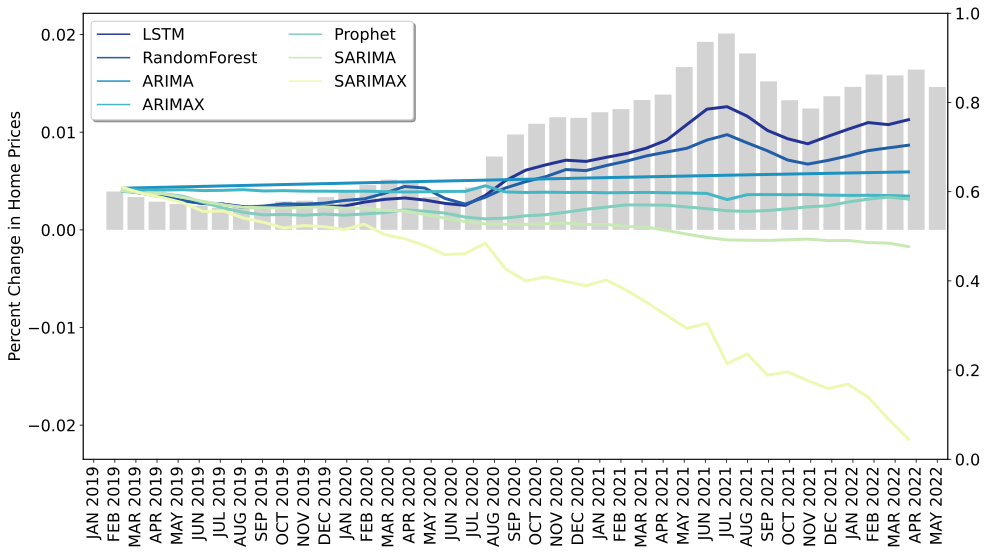

In [40]:
df_time1_test_raw["time"] = df_time1_test_raw["time"].dt.strftime('%b %Y').str.upper()
housing_price = pd.DataFrame(df_time1_test_raw['housing_price'].pct_change())
housing_price["time"] = df_time1_test_raw["time"]
housing_price.columns = ["price", "time"]
housing_price = housing_price.reset_index()

# reformating results to plot
ARIMAX = pd.DataFrame(df_results['predicted_housing_price_ARIMAX1'].pct_change())
ARIMAX["time"] = df_time1_test_raw["time"]
ARIMAX.columns = ["price", "time"]
ARIMAX["model"] = 'ARIMAX'
ARIMAX = ARIMAX.reset_index()
SARIMAX = pd.DataFrame(df_results['predicted_housing_price_SARIMAX1'].pct_change())
SARIMAX["time"] = df_time1_test_raw["time"]
SARIMAX.columns = ["price", "time"]
SARIMAX["model"] = 'SARIMAX'
SARIMAX = SARIMAX.reset_index()
ARIMA = pd.DataFrame(df_results['housing_price_ARIMA_forecast'].pct_change())
ARIMA["time"] = df_time1_test_raw["time"]
ARIMA.columns = ["price", "time"]
ARIMA["model"] = 'ARIMA'
ARIMA = ARIMA.reset_index()
SARIMA = pd.DataFrame(df_results['housing_price_SARIMA_forecast'].pct_change())
SARIMA["time"] = df_time1_test_raw["time"]
SARIMA.columns = ["price", "time"]
SARIMA["model"] = 'SARIMA'
SARIMA = SARIMA.reset_index()
LSTM = pd.DataFrame(df_results['housing_price_LSTM_forecast'].pct_change())
LSTM["time"] = df_time1_test_raw["time"]
LSTM.columns = ["price", "time"]
LSTM["model"] = 'LSTM'
LSTM = LSTM.reset_index()
RandomForest = pd.DataFrame(df_results['housing_price_Randomforest_forecast'].pct_change())
RandomForest["time"] = df_time1_test_raw["time"]
RandomForest.columns = ["price", "time"]
RandomForest["model"] = 'RandomForest'
RandomForest = RandomForest.reset_index()
Prophet = pd.DataFrame(df_results['housing_price_Prophet_forecast'].pct_change())
Prophet["time"] = df_time1_test_raw["time"]
Prophet.columns = ["price", "time"]
Prophet["model"] = 'Prophet'
Prophet = Prophet.reset_index()
models = pd.concat([ARIMA, SARIMA, ARIMAX, SARIMAX, RandomForest, Prophet, LSTM], axis=0).dropna().reset_index()

# plot!
plt.rcParams.update({'font.size': 16})
hue_order = ["LSTM", "RandomForest", "ARIMA", "ARIMAX", "Prophet", "SARIMA", "SARIMAX"]
fig, ax1 = plt.subplots(figsize=(14,8))
sns.barplot(x="time", y="price", data=housing_price, color="lightgrey", ax=ax1)
plt.xticks(housing_price.index, housing_price["time"].values, rotation=90)
ax2 = ax1.twinx()
ax2 = ax1.twiny()
sns.lineplot(x="time", y="price", hue="model", data=models, palette="YlGnBu_r", hue_order= hue_order, ax=ax2, linewidth=3)
ax2.set(xlabel=None)
ax2.set(ylabel=None)
ax1.set(ylabel="Percent Change in Home Prices")
ax2.legend(loc='upper left',  ncol = 2, fancybox=True, shadow=True)
ax1.set(xlabel=None)
ax2.axis('off')
plt.tight_layout()
plt.savefig('models.png', dpi=600, transparent=False)

LSTM has the best performance reaching about 96.4% accuracy in predicting housing prices during COVID. Our seasonality models perform poorly, most likely because we corrected for any seasonality trends during our EDA so they are modeling weak or non-exisiting trends. 

## Accuracy metrics 

In [42]:
# y_test: for example housing_price 2019-2022 (df_test)
# y_predict: in-sample prediction, for example, prediction by model for housing_price 2019-2022


#Input the test and prediceted array from the models

y_test = df_time1_test_raw["housing_price"]

y_predict_arima = df_results["housing_price_ARIMA_forecast"]
y_predict_arimax = df_results["predicted_housing_price_ARIMAX1"]
y_predict_sarima = df_results["housing_price_SARIMA_forecast"]
y_predict_sarimax = df_results["predicted_housing_price_SARIMAX1"]
y_predict_lstm = df_results["housing_price_LSTM_forecast"]
y_predict_rf = df_results["housing_price_Randomforest_forecast"]
y_predict_np = df_results["housing_price_Prophet_forecast"]


# -------MAE: The easiest to understand. Represents average error
mae_arima = metrics.mean_absolute_error(y_test, y_predict_arima)
mae_arimax = metrics.mean_absolute_error(y_test, y_predict_arimax)
mae_sarima = metrics.mean_absolute_error(y_test, y_predict_sarima)
mae_sarimax = metrics.mean_absolute_error(y_test, y_predict_sarimax)
mae_lstm = metrics.mean_absolute_error(y_test, y_predict_lstm)
mae_rf = metrics.mean_absolute_error(y_test, y_predict_rf)  #random forest
mae_np = metrics.mean_absolute_error(y_test, y_predict_np)  #neural prophet

# ------MAPE: MAPE can be problematic. Most pointedly, it can cause division-by-zero errors. https://en.wikipedia.org/wiki/Mean_absolute_percentage_error#Issues
mape_arima = metrics.mean_absolute_percentage_error(y_test, y_predict_arima)
mape_arimax = metrics.mean_absolute_percentage_error(y_test, y_predict_arimax)
mape_sarima = metrics.mean_absolute_percentage_error(y_test, y_predict_sarima)
mape_sarimax = metrics.mean_absolute_percentage_error(y_test, y_predict_sarimax)
mape_lstm = metrics.mean_absolute_percentage_error(y_test, y_predict_lstm)
mape_rf = metrics.mean_absolute_percentage_error(y_test, y_predict_rf)
mape_np = metrics.mean_absolute_percentage_error(y_test, y_predict_np)

# ------MSE: Similar to MAE but noise is exaggerated and larger errors are “punished”. It is harder to interpret than MAE as it’s not in base units, however, it is generally more popular.
mse_arima = metrics.mean_squared_error(y_test, y_predict_arima)
mse_arimax = metrics.mean_squared_error(y_test, y_predict_arimax)
mse_sarima = metrics.mean_squared_error(y_test, y_predict_sarima)
mse_sarimax = metrics.mean_squared_error(y_test, y_predict_sarimax)
mse_lstm = metrics.mean_squared_error(y_test, y_predict_lstm)
mse_rf = metrics.mean_squared_error(y_test, y_predict_rf)
mse_np = metrics.mean_squared_error(y_test, y_predict_np)

# -----RMSE: Most popular metric, similar to MSE, however, the result is square rooted to make it more interpretable as it’s in base units. It is recommended that RMSE be used as the primary metric to interpret your model.
rmse_arima = np.sqrt(metrics.mean_squared_error(y_test, y_predict_arima))
rmse_arimax = np.sqrt(metrics.mean_squared_error(y_test, y_predict_arimax))
rmse_sarima = np.sqrt(metrics.mean_squared_error(y_test, y_predict_sarima))
rmse_sarimax = np.sqrt(metrics.mean_squared_error(y_test, y_predict_sarimax))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, y_predict_lstm))
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_predict_rf))
rmse_np = np.sqrt(metrics.mean_squared_error(y_test, y_predict_np))

# -----RMSLE: 
#ref: https://hrngok.github.io/posts/metrics/#:~:text=Root%20Mean%20Squared%20Logaritmic%20Error%20(RMSLE)&text=It%20is%20the%20Root%20Mean,possible%200%20(zero)%20values.
# It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values.
# RMSLE adds 1 to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible 0 (zero) values.
# As a result, the function can be used if actual or predicted have zero-valued elements. But this function is not appropriate if either is negative valued

rmsle_arima = metrics.mean_squared_log_error(y_test, y_predict_arima, squared=False)   #squared=True --> MSLE, =False --> RMSLE
rmsle_arimax = metrics.mean_squared_log_error(y_test, y_predict_arimax, squared=False)
rmsle_sarima = metrics.mean_squared_log_error(y_test, y_predict_sarima, squared=False)
rmsle_sarimax = metrics.mean_squared_log_error(y_test, y_predict_sarimax, squared=False)
rmsle_lstm = metrics.mean_squared_log_error(y_test, y_predict_lstm, squared=False)
rmsle_rf = metrics.mean_squared_log_error(y_test, y_predict_rf, squared=False)
rmsle_np = metrics.mean_squared_log_error(y_test, y_predict_np, squared=False)

# ------R^2
R2_arima = metrics.r2_score(y_test, y_predict_arima)
R2_arimax = metrics.r2_score(y_test, y_predict_arimax)
R2_sarima = metrics.r2_score(y_test, y_predict_sarima)
R2_sarimax = metrics.r2_score(y_test, y_predict_sarimax)
R2_lstm = metrics.r2_score(y_test, y_predict_lstm)
R2_rf = metrics.r2_score(y_test, y_predict_rf)
R2_np = metrics.r2_score(y_test, y_predict_np)

# ------ create table of those metrics
d = {'Model': ['ARIMA', 'ARIMAX', 'SARIMA', 'SARIMAX', 'LSTM',  'Prophet', 'Random Forest'],
     'R_squared': [R2_arima, R2_arimax, R2_sarima, R2_sarimax, R2_lstm,  R2_np,  R2_rf],
     'MAE': [mae_arima, mae_arimax, mae_sarima, mae_sarimax, mae_lstm, mae_np, mae_rf],
     'MAPE': [mape_arima, mape_arimax, mape_sarima, mape_sarimax, mape_lstm,  mape_np,  mape_rf],
     'MSE': [mse_arima, mse_arimax, mse_sarima, mse_sarimax, mse_lstm,  mse_np,  mse_rf],
     'RMSE': [rmse_arima, rmse_arimax, rmse_sarima, rmse_sarimax, rmse_lstm, rmse_np, rmse_rf],
    'RMSLE': [rmsle_arima, rmsle_arimax, rmsle_sarima, rmsle_sarimax, rmsle_lstm, rmsle_np, rmsle_rf]
     }

accuracy_table = pd.DataFrame(data=d)
accuracy_table = accuracy_table.round(3) 

accuracy_table.to_csv('/content/drive/MyDrive/ds4_housing_data/accuracy_table.csv')
accuracy_table


,Model,R_squared,MAE,MAPE,MSE,RMSE,RMSLE
0,ARIMA,0.632,12721.539,0.041,3.967014e+08,19917.365,0.064
1,ARIMAX,0.366,16147.179,0.051,6.837701e+08,26148.997,0.086
2,SARIMA,-0.513,25684.065,0.082,1.631801e+09,40395.560,0.140
3,SARIMAX,-2.757,41678.398,0.134,4.053508e+09,63667.168,0.241
4,LSTM,0.728,11324.198,0.036,2.930570e+08,17118.909,0.056
5,Prophet,-0.191,23436.644,0.075,1.285031e+09,35847.334,0.123
6,Random Forest,0.615,12813.605,0.041,4.149236e+08,20369.673,0.066


LSTM has the highest R_squared and the lowest mean average percent error